# Lab 6: Constrained optimization: inequality constraints

Àlex Escolà Nixon

The orthogonal projection function, already provided:

In [2]:
def orthogonal_projection(gradient, y, sides):
    import sys
    import numpy as np

    m = y.size
    if (len(sides) > m):
        sys.exit("Error: len(sides) > m")

    # We normalize y. We use a vector y equal to zeros to simulate no hyperplane
    norm = np.linalg.norm(y)
    y_normalized = y.copy()
    if not (norm == 0):
        y_normalized = y_normalized / np.linalg.norm(y)

    # We now apply the Gram-Schmidt algorithm to construct the
    # projection subspace S
    c_ortho = np.zeros((len(sides),m))
    for i in range(len(sides)):
        c_ortho[i,sides[i]] = 1.0;
        c_ortho[i,:] = c_ortho[i,:] - np.dot(c_ortho[i,:], y_normalized) * y_normalized
        for j in range(0,i):
            c_ortho[i,:] = c_ortho[i,:] - np.dot(c_ortho[i,:], c_ortho[j,:]) * c_ortho[j,:]
        c_ortho[i,:] = c_ortho[i,:] / np.linalg.norm(c_ortho[i,:])
        
    # This is the gradient projection orthogonal to the subspace S constructed
    # previously
    g_project = gradient.copy()
    g_project = g_project - np.dot(g_project, y_normalized) * y_normalized
    for i in range(len(sides)):
        g_project = g_project - np.dot(g_project, c_ortho[i,:]) * c_ortho[i,:]  
        
    return g_project

Here the algorithm is tested with two data points. Lower down as specified the matrices A and h are computed for the alogrithm to perform the iterations with the same provided code. Further on w and b are calculated in order to define the support vectors and classify the new points. 
In order to calculate w, as specified, we consider thoes values in this sumation according to the indexes of $\alpha$ in which its value is strictly positive.

\begin{equation}
w=\sum_{i \in SV} \alpha_i y_i x_i
\end{equation}

As specified in the practice statements, when the alphas are in the range $0<\alpha_j < C$, the given corresponding data point is used in order to compute the value ob b, where the average of these points is taken.
Here we begin with two data points:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Try this first!!! We have one sample for each class!!!
#c1 = np.array([[0.5, 0.3], [0.0, 0.0]])
#c2 = np.array([[5.0, 6.0], [4.0, 5.5]])

c1 = np.array([[0.5, 0.3]])
c2 = np.array([[5.0, 6.0]])

# Perform the plot
fig = plt.figure()
plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.xlim([-10, 10])
plt.ylim([-10, 10])

# We concatenate the data of c1 and c2. Take into account that variable
# "y" is our hyperplane. 
x = np.r_[c1,c2]
y = np.r_[-np.ones(c1.shape[0]),np.ones(c2.shape[0])]

# Let us now construct matrices X and Y as explained in the lab document.
m = y.size
print "The problem has", m, "training elements"

# This is the restriction cube. You may use different values of C.
C = 1000000.0  
sides = []
               
# Our initial values for alpha. The initial point has to be over the
# hyperplane
alpha = np.empty(m)
alpha.fill(0.0)    
               
# Construct matrices A and h in order to be able to use the code
# from this notebook! We are going to minimize the quadratic function 
# f(alpha) = 0.5 * alpha^T * A * alpha - h^T * alpha 

A=np.diag(y).dot(x).dot(x.T).dot(np.diag(y))
h=np.ones(m)

# Perform now the iterations. 
               
# Iterations
cont = 0
while (cont < 100):
    cont=cont+1
    #print "Iteration", cont
    
    # Gradient of the quadratic form
    gradient = np.dot(A, alpha) - h
    descent  = - gradient.copy()
    
    # This is the search direction, that is, the gradient projected taking into 
    # account the restriction of the cube
    p = orthogonal_projection(descent, y, sides)
    
    # We manually set to zero the search direction if we are on side "i"
    for i in sides:
        p[i] = 0.0
        
    #print "   Descent is", p
        
    # Compute the norm of p. Just to be sure that we can move. 
    norm = np.linalg.norm(p)
    if (norm < 1e-10):
        print "Norm of p very small! Finished!"
        break

    # Compute the optimum value of beta, the search step
    beta_opt_denominator = np.dot(p, np.dot(A,p))
    beta_opt_numerator   = np.dot(p, h - np.dot(A,alpha)) 
    beta_opt = (beta_opt_numerator / beta_opt_denominator)
    
    #print "   beta_opt is", beta_opt
    
    # Which is the maximum value of beta that can be taken?
    # Since the function to minimize is quadratic we have to add 
    # new elements to sides (i.e. no elements are removed from sides)
    beta_max = beta_opt
    for i in range(m):
        if not i in sides:
            if (p[i] > 0):    # We move to the upper face of the restriction
                beta_tmp = (C - alpha[i]) / p[i]
            elif (p[i] < 0):  # We move to the lower face of the restriction
                beta_tmp = ( - alpha[i] ) / p[i]
                
            if (beta_tmp < beta_max):
                beta_max = beta_tmp
                sides.extend([i])
                
    #print "   beta_max is", beta_max
                
    # Update the value of alpha            
    alpha_new = alpha + beta_max * p
    
    # Plot
    #plt.plot([alpha[0], alpha_new[0]], [alpha[1], alpha_new[1]], 'r')
    
    # Update
    alpha = alpha_new
               
# Once iterations are finished, recover the value of w and b.
# The equations are indicated in the document.
print "Iteration =", cont
print "alpha =", alpha
sv=np.where(alpha>0)
w=x[sv].T.dot(np.diag(y[sv])).dot(alpha[sv])
print "w =", w

#Average of the b points encountered
b=sum(y[sv]-w.T.dot(x[sv].T))/len(sv[0])
print "b =", b

The problem has 2 training elements
Norm of p very small! Finished!
Iteration = 2
alpha = [ 0.03792188  0.03792188]
w = [ 0.17064846  0.21615472]
b = -1.15017064846


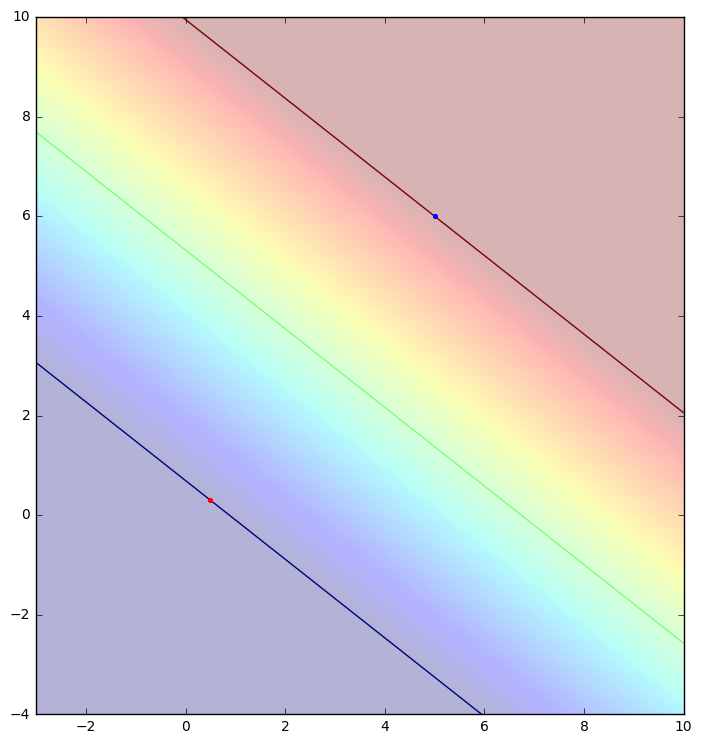

In [7]:
# Some plot would be fine
xx,yy = np.meshgrid(np.linspace(-3,10,200),np.linspace(-4,10,200))
viz=np.c_[xx.ravel(),yy.ravel()]


z = np.dot(viz,w)+b

plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.gca().set_xlim([-3.,10.])
plt.gca().set_ylim([-4.,10.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-3,10,-4,10),alpha=0.3, vmin=-1, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)),[-1.,0.,1.])

plt.gcf().set_size_inches((9,9))
plt.show()

Here we now try with more data points. These are generated from a multivariate Normal distribution.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Once the previous works, try with this
# Generate random data. The next code is of Oriols' notebook.
m1 = [0.,0.]
s1 = [[1,-0.9],[-0.9,1]]
m2 = [3.,6.]
s2 = [[1,0],[0,1]]
c1 = np.random.multivariate_normal(m1,s1,50)
c2 = np.random.multivariate_normal(m2,s2,50)

# Perform the plot
fig = plt.figure()
plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.xlim([-10, 10])
plt.ylim([-10, 10])

# We concatenate the data of c1 and c2. Take into account that variable
# "y" is our hyperplane. 
x = np.r_[c1,c2]
y = np.r_[-np.ones(c1.shape[0]),np.ones(c2.shape[0])]

# Let us now construct matrices X and Y as explained in the lab document.
m = y.size
print "The problem has", m, "training elements"

# This is the restriction cube. You may use different values of C.
C = 1000000.  
sides = []
               
# Our initial values for alpha. The initial point has to be over the
# hyperplane
alpha = np.empty(m)
alpha.fill(0.0)    
               
# Construct matrices A and h in order to be able to use the code
# from this notebook! We are going to minimize the quadratic function 
# f(alpha) = 0.5 * alpha^T * A * alpha - h^T * alpha 

# TODO TODO: PUT YOUR CODE HERE!!!

A=np.diag(y).dot(x).dot(x.T).dot(np.diag(y))
h=np.ones(m)

# Perform now the iterations. 
               
# TODO TODO: PUT YOUR CODE HERE!!!

# Iterations
cont = 0
while (cont < 100):
    cont=cont+1
    #print "Iteration", cont
    
    # Gradient of the quadratic form
    gradient = np.dot(A, alpha) - h
    descent  = - gradient.copy()
    
    # This is the search direction, that is, the gradient projected taking into 
    # account the restriction of the cube
    p = orthogonal_projection(descent, y, sides)
    
    # We manually set to zero the search direction if we are on side "i"
    for i in sides:
        p[i] = 0.0
        
    #print "   Descent is", p
        
    # Compute the norm of p. Just to be sure that we can move. 
    norm = np.linalg.norm(p)
    if (norm < 1e-10):
        print "Norm of p very small! Finished!"
        break

    # Compute the optimum value of beta, the search step
    beta_opt_denominator = np.dot(p, np.dot(A,p))
    beta_opt_numerator   = np.dot(p, h - np.dot(A,alpha)) 
    beta_opt = (beta_opt_numerator / beta_opt_denominator)
    
    #print "   beta_opt is", beta_opt
    
    # Which is the maximum value of beta that can be taken?
    # Since the function to minimize is quadratic we have to add 
    # new elements to sides (i.e. no elements are removed from sides)
    beta_max = beta_opt
    for i in range(m):
        if not i in sides:
            if (p[i] > 0):    # We move to the upper face of the restriction
                beta_tmp = (C - alpha[i]) / p[i]
            elif (p[i] < 0):  # We move to the lower face of the restriction
                beta_tmp = ( - alpha[i] ) / p[i]
                
            if (beta_tmp < beta_max):
                beta_max = beta_tmp
                sides.extend([i])
                
    #print "   beta_max is", beta_max
                
    # Update the value of alpha            
    alpha_new = alpha + beta_max * p
    
    # Plot
    #plt.plot([alpha[0], alpha_new[0]], [alpha[1], alpha_new[1]], 'r')
    
    # Update
    alpha = alpha_new
               
# Once iterations are finished, recover the value of w and b.
# The equations are indicated in the document.
print "Iteration =", cont
print "alpha =", alpha
sv=np.where(alpha>0)
w=x[sv].T.dot(np.diag(y[sv])).dot(alpha[sv])
print "w =", w

#Average of the b points encountered
b=sum(y[sv]-w.T.dot(x[sv].T))/m
print "b =", b

The problem has 100 training elements
Iteration = 100
alpha = [  9.79071249e-04   1.29839999e-03   5.72598810e-04   8.98396157e-04
   9.81394487e-04   8.03187859e-02   8.84063032e-04   2.22737415e-04
   3.35114021e-04   1.19840664e-04   8.04472931e-04   8.08993124e-04
   0.00000000e+00   1.15355303e-03   1.73831866e-03   5.46021944e-04
   5.90496348e-04   1.78806868e-03   7.24938895e-04   1.13248498e-03
   0.00000000e+00   1.41115758e-03   3.91935804e-03   8.32801378e-04
   8.67361738e-19   1.08258104e-03   2.67512799e-04   7.01368279e-04
   9.18235606e-04   3.86603765e-04   0.00000000e+00   9.08659102e-04
   1.13452323e-03   6.85696779e-04   7.41999322e-04   5.84215279e-04
   5.70608674e-04   2.08627146e-03   2.81780831e-04   0.00000000e+00
   1.63567844e-04   3.05947540e-04   0.00000000e+00   5.08798379e-03
   1.20068177e-04   0.00000000e+00   9.96553965e-04   1.19135397e-03
   1.54731938e-02   1.13825703e-03   1.15228404e-03   0.00000000e+00
   0.00000000e+00   1.98371151e-04   1.89

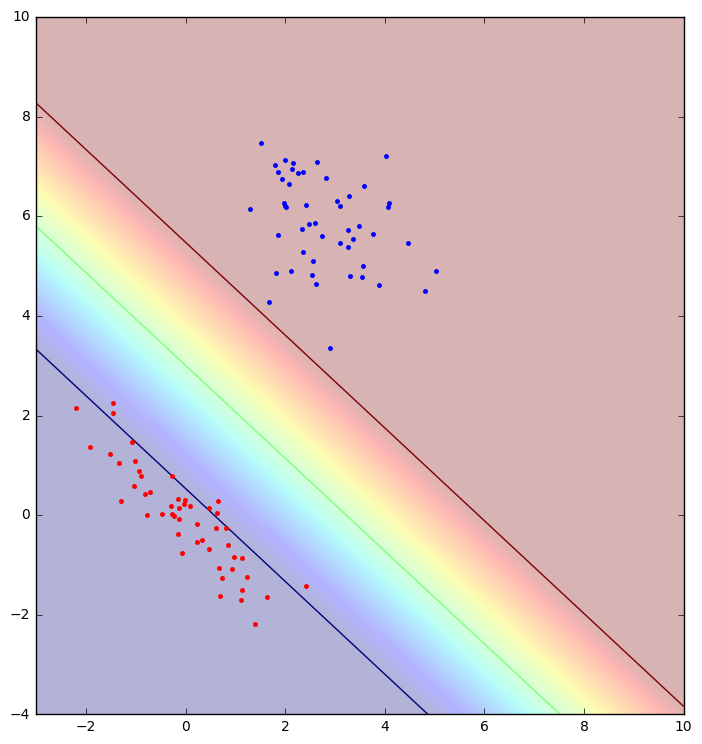

In [5]:
# Some plot would be fine
# TODO TODO: PUT YOUR CODE HERE!!!
xx,yy = np.meshgrid(np.linspace(-3,10,200),np.linspace(-4,10,200))
viz=np.c_[xx.ravel(),yy.ravel()]


z = np.dot(viz,w)+b

plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.gca().set_xlim([-3.,10.])
plt.gca().set_ylim([-4.,10.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-3,10,-4,10),alpha=0.3, vmin=-1, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)),[-1.,0.,1.])

plt.gcf().set_size_inches((9,9))
plt.show()